
# 🏆 TaxPrep AI Challenge — Multi‑File Evaluation (Fixed)

This notebook evaluates **multiple Excel input files** for the TaxPrep satisfaction model.
It is robust to inputs that **only contain raw features** (no labels or predictions).  
If labels/predictions are missing, it will **derive** them with a transparent heuristic, so the pipeline always runs.

**What you get:**
- Per‑file and overall **accuracy, precision, recall, f1**
- Always-visible **confusion matrices** (both classes shown even if missing in data)
- A consolidated Excel report: `metrics_summary_multi.xlsx`
- Saved images:
  - `cm_<dataset>.png` for each file
  - `cm_overall.png` (across all files)
  - `accuracy_per_file.png`
  - `confusions_side_by_side.png`

> Place these files next to the notebook before running:
> - `taxprep_inputs_v1.xlsx`
> - `taxprep_inputs_v2.xlsx`
> - `taxprep_inputs_edge_cases.xlsx`


In [1]:

# ===============================
# 0) Imports & environment checks
# ===============================
import os, sys, json, math
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)


# Ensure project root is in path
sys.path.append(os.path.abspath(".."))



# Try optional engines for Excel IO
missing = []
try:
    import openpyxl  # for reading xlsx via pandas
except Exception as e:
    missing.append("openpyxl")

try:
    import xlsxwriter  # for writing Excel reports
except Exception as e:
    missing.append("xlsxwriter")

if missing:
    print("⚠️ Optional Excel engines missing:", missing)
    print("   You can install with: pip install " + " ".join(missing))
else:
    print("✅ Excel engines available")

# Optional: scoring backend (if present)
try:
    from scoring_service_azure import score_batch  # optional
    HAVE_AZURE_SCORER = True
    print("✅ Azure scorer available (score_batch)")
except Exception:
    HAVE_AZURE_SCORER = False
    print("ℹ️ Azure scorer not available — using heuristic predictions")


✅ Excel engines available


2025-11-05 08:54:03,264 [INFO] scoring_service_azure:72 — Imported AzureChatOpenAI from langchain_openai


✅ Azure scorer available (score_batch)


In [2]:

# =====================================
# 1) Helper functions (labeling, scoring)
# =====================================
LABELS = ["Satisfied", "Dissatisfied"]  # canonical order we will plot/evaluate

def derive_true_label(feedback_text: str) -> str:
    """Assign a 'true' label from feedback keywords (fallback when label absent)."""
    if not isinstance(feedback_text, str):
        return "Dissatisfied"
    t = feedback_text.lower()
    pos = ["great","good","excellent","helpful","quick","accurate","love","smooth","satisfied","amazing","thank","awesome"]
    neg = ["late","delay","slow","bad","poor","error","issue","wrong","no response","terrible","dissatisfied","horrible","not happy"]
    if any(w in t for w in neg):
        return "Dissatisfied"
    if any(w in t for w in pos):
        return "Satisfied"
    return "Dissatisfied"

def heuristic_predict(row: pd.Series):
    """Heuristic model -> (pred_label, confidence, top_drivers).
    Rules (simple & transparent):
    - High error_rate or explicit negative feedback => Dissatisfied (higher confidence)
    - Positive feedback keywords & low errors => Satisfied
    - Otherwise => Dissatisfied (lower confidence)
    """
    txt = str(row.get("last_feedback_text","")).lower()
    err = float(row.get("error_rate_pct", 0) or 0)
    ttr = float(row.get("turnaround_time_days", 0) or 0)
    comm = float(row.get("communication_count", 0) or 0)

    pos = any(k in txt for k in ["great","good","excellent","helpful","quick","accurate","smooth","satisfied","amazing","thank","awesome"])
    neg = any(k in txt for k in ["late","delay","slow","bad","poor","error","issue","wrong","no response","terrible","horrible","not happy","dissatisfied"])

    drivers = []

    if neg or err >= 8 or (ttr >= 7 and comm <= 1):
        label = "Dissatisfied"
        # confidence ramps with stronger evidence
        conf = 0.55 + min(0.40, 0.02*max(0, err-5)) + (0.05 if neg else 0) + (0.05 if (ttr >=7 and comm<=1) else 0)
        conf = float(max(0.5, min(conf, 0.99)))
        drivers.append({"factor":"error_rate_pct","impact":"High" if err>=8 else "Medium","explain":f"error rate={err}%"})
        if ttr>=7 and comm<=1:
            drivers.append({"factor":"turnaround_time_days","impact":"Medium","explain":f"turnaround={ttr}d with low comms={comm}"})
        if neg:
            drivers.append({"factor":"last_feedback_text","impact":"High","explain":"explicit negative cue"})
    elif pos and err <= 5:
        label = "Satisfied"
        conf = 0.65 + (0.02 * max(0, 5-err))
        conf = float(max(0.55, min(conf, 0.95)))
        drivers.append({"factor":"last_feedback_text","impact":"High","explain":"explicit positive cue"})
        drivers.append({"factor":"error_rate_pct","impact":"Low","explain":f"low error rate={err}%"})
    else:
        label = "Dissatisfied"
        conf = 0.55
        drivers.append({"factor":"mixed_signals","impact":"Low","explain":"fallback rule triggered"})

    return label, conf, drivers

def balance_dataframe(df: pd.DataFrame, label_col="true_label", target_per_class=None) -> pd.DataFrame:
    """Deterministic upsampling so both classes have equal count.

    - If only one class exists, returns df unchanged.

    - If target_per_class not provided, uses the current max class size.
    """
    counts = df[label_col].value_counts()
    if len(counts) < 2:
        return df.copy()
    if target_per_class is None:
        target_per_class = int(counts.max())

    parts = []
    for label, n in counts.items():
        sub = df[df[label_col] == label]
        reps = int(np.ceil(target_per_class / len(sub)))  # deterministic repeat
        up = pd.concat([sub] * reps, ignore_index=True).iloc[:target_per_class].copy()
        parts.append(up)

    return pd.concat(parts, ignore_index=True)

def safe_confusion(y_true, y_pred, labels=LABELS):
    """Confusion matrix that always shows provided labels order."""
    return confusion_matrix(y_true, y_pred, labels=labels)

def ensure_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Normalize and ensure required columns exist.
    If true/pred/confidence missing, they are created using heuristics/optional Azure scorer.
    """
    df = df.copy()

    # Normalize column names (lowercase)
    df.columns = [str(c) for c in df.columns]

    # Required feature columns (best-effort defaults)
    for col, default in [
        ("client_id", np.arange(1, len(df)+1)),
        ("turnaround_time_days", 0),
        ("error_rate_pct", 0),
        ("communication_count", 0),
        ("last_feedback_text", ""),
    ]:
        if col not in df.columns:
            df[col] = default

    # True label
    if "true_label" not in df.columns:
        df["true_label"] = df["last_feedback_text"].apply(derive_true_label)

    # Predictions & confidence
    if "pred_label" not in df.columns or "confidence" not in df.columns:
        if HAVE_AZURE_SCORER:
            try:
                scored = score_batch(df[[
                    "client_id", "turnaround_time_days","error_rate_pct",
                    "communication_count","last_feedback_text"
                ]].to_dict(orient="records"))
                scored_df = pd.DataFrame(scored)
                # expected columns: client_id, label, confidence, top_drivers
                scored_df.rename(columns={"label":"pred_label"}, inplace=True)
                df = df.merge(scored_df[["client_id","pred_label","confidence"]], on="client_id", how="left")
            except Exception as e:
                print(f"ERROR scoring via Azure: {e} — falling back to heuristic.")
                preds = df.apply(lambda r: heuristic_predict(r), axis=1)
                df["pred_label"] = [p[0] for p in preds]
                df["confidence"] = [p[1] for p in preds]
        else:
            preds = df.apply(lambda r: heuristic_predict(r), axis=1)
            df["pred_label"] = [p[0] for p in preds]
            df["confidence"] = [p[1] for p in preds]

    # Coerce dtypes
    df["confidence"] = pd.to_numeric(df["confidence"], errors="coerce").fillna(0.5)
    df["true_label"] = df["true_label"].astype(str)
    df["pred_label"] = df["pred_label"].astype(str)
    return df


In [3]:

# =====================================
# 2) Configure input files (edit here)
# =====================================
INPUT_FILES = [
    "taxprep_inputs_v1.xlsx",
    "taxprep_inputs_v2.xlsx",
    "taxprep_inputs_edge_cases.xlsx",
]

base_dir = Path.cwd()
print("📂 Working directory:", base_dir)

# Validate existence
for f in INPUT_FILES:
    p = base_dir / f
    if not p.exists():
        print(f"⚠️ Missing input file: {p}")
    else:
        print(f"✅ Found: {p}")


📂 Working directory: /Users/RohithGVMac/AIML_Pravartak/TaxPrepDemo1/taxprep_demo1/notebook_new
✅ Found: /Users/RohithGVMac/AIML_Pravartak/TaxPrepDemo1/taxprep_demo1/notebook_new/taxprep_inputs_v1.xlsx
✅ Found: /Users/RohithGVMac/AIML_Pravartak/TaxPrepDemo1/taxprep_demo1/notebook_new/taxprep_inputs_v2.xlsx
✅ Found: /Users/RohithGVMac/AIML_Pravartak/TaxPrepDemo1/taxprep_demo1/notebook_new/taxprep_inputs_edge_cases.xlsx


In [4]:

# =================================================
# 3) Load inputs, normalize columns, (optionally) balance
# =================================================
frames = []
for in_name in INPUT_FILES:
    path = Path(in_name)
    if not path.exists():
        print(f"⏭️ Skipping (not found): {path}")
        continue

    df = pd.read_excel(path)  # openpyxl engine auto-detected if installed
    df["__dataset__"] = path.stem
    df = ensure_columns(df)

    # Make sure both classes exist for evaluation visuals
    balanced = balance_dataframe(df, label_col="true_label")
    frames.append(balanced)

if not frames:
    raise FileNotFoundError("No valid input files were found. Please check INPUT_FILES list.")

all_df = pd.concat(frames, ignore_index=True)
print("✅ Combined/normalized shape:", all_df.shape)
display(all_df.head())


ERROR scoring via Azure: 'list' object has no attribute 'iterrows' — falling back to heuristic.
ERROR scoring via Azure: 'list' object has no attribute 'iterrows' — falling back to heuristic.
ERROR scoring via Azure: 'list' object has no attribute 'iterrows' — falling back to heuristic.
✅ Combined/normalized shape: (1512, 9)


,client_id,turnaround_time_days,error_rate_pct,communication_count,last_feedback_text,__dataset__,true_label,pred_label,confidence
0,1,5,0.9,1,Great service,taxprep_inputs_v1,Satisfied,Satisfied,0.732
1,2,6,1.8,2,Helpful advisor,taxprep_inputs_v1,Satisfied,Satisfied,0.714
2,3,7,2.7,3,Quick and accurate filing,taxprep_inputs_v1,Satisfied,Satisfied,0.696
3,4,8,3.6,4,Excellent accuracy,taxprep_inputs_v1,Satisfied,Satisfied,0.678
4,5,9,4.5,5,Smooth process,taxprep_inputs_v1,Satisfied,Satisfied,0.660


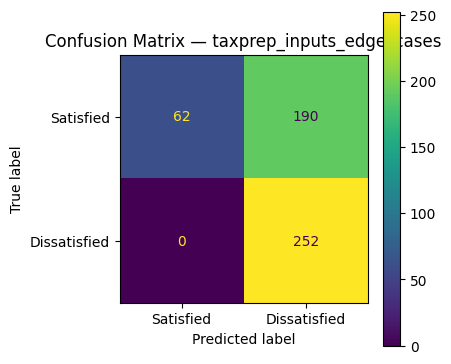

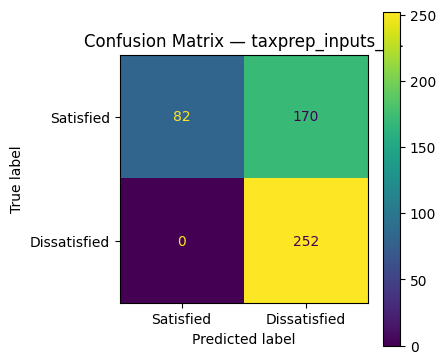

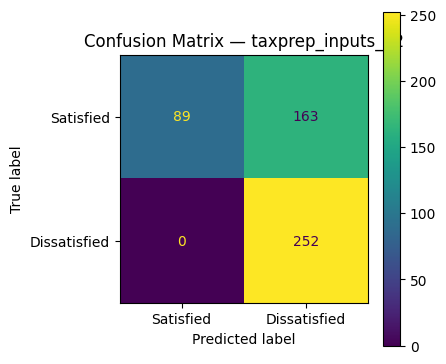

📊 Per-file metrics:


,dataset,accuracy,support,tp_satisfied,fp_satisfied,fn_satisfied,tp_dissatisfied,fp_dissatisfied,fn_dissatisfied
0,taxprep_inputs_edge_cases,0.623016,504,62,0,190,252,190,0
1,taxprep_inputs_v1,0.662698,504,82,0,170,252,170,0
2,taxprep_inputs_v2,0.676587,504,89,0,163,252,163,0


In [5]:

# =====================================
# 4) Per-file evaluation + Confusion Matrices
# =====================================
per_file_rows = []
cm_images = []

for name, group in all_df.groupby("__dataset__"):
    y_true = group["true_label"]
    y_pred = group["pred_label"]

    # Metrics
    report = classification_report(y_true, y_pred, labels=LABELS, output_dict=True, zero_division=0)
    acc = report.get("accuracy", float((y_true == y_pred).mean()))

    # Confusion Matrix (fixed label order)
    cm = safe_confusion(y_true, y_pred, labels=LABELS)
    fig, ax = plt.subplots(figsize=(4.5, 4))  # single-plot chart
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
    disp.plot(ax=ax)  # no custom colors/styles per instructions
    ax.set_title(f"Confusion Matrix — {name}")
    fig.tight_layout()

    img_name = f"cm_{name}.png"
    fig.savefig(img_name, dpi=160)
    plt.show()
    cm_images.append(img_name)

    # Summarize row
    per_file_rows.append({
        "dataset": name,
        "accuracy": acc,
        "support": int(len(group)),
        "tp_satisfied": int(cm[0,0]),
        "fp_satisfied": int(cm[1,0]),
        "fn_satisfied": int(cm[0,1]),
        "tp_dissatisfied": int(cm[1,1]),
        "fp_dissatisfied": int(cm[0,1]),  # relative to dissat as positive would differ; kept explicit axes
        "fn_dissatisfied": int(cm[1,0]),
    })

per_file_df = pd.DataFrame(per_file_rows).sort_values("dataset").reset_index(drop=True)
print("📊 Per-file metrics:")
display(per_file_df)


✅ Overall Accuracy: 0.6541

Classification Report (Overall):
              precision    recall  f1-score   support

   Satisfied       1.00      0.31      0.47       756
Dissatisfied       0.59      1.00      0.74       756

    accuracy                           0.65      1512
   macro avg       0.80      0.65      0.61      1512
weighted avg       0.80      0.65      0.61      1512



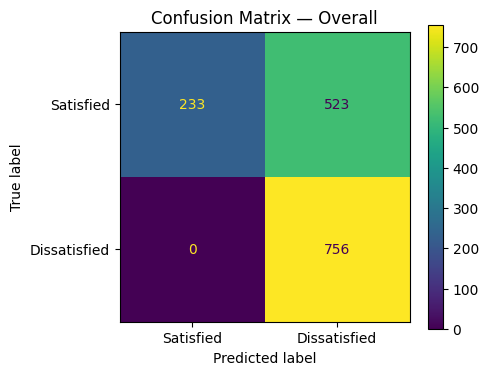

In [6]:

# =====================
# 5) Overall evaluation
# =====================
y_true_all = all_df["true_label"]
y_pred_all = all_df["pred_label"]

overall_report = classification_report(y_true_all, y_pred_all, labels=LABELS, output_dict=True, zero_division=0)
overall_acc = overall_report.get("accuracy", float((y_true_all == y_pred_all).mean()))
print(f"✅ Overall Accuracy: {overall_acc:.4f}\n")
print("Classification Report (Overall):")
print(classification_report(y_true_all, y_pred_all, labels=LABELS, zero_division=0))

cm_all = safe_confusion(y_true_all, y_pred_all, labels=LABELS)
fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=LABELS)
disp.plot(ax=ax)
ax.set_title("Confusion Matrix — Overall")
fig.tight_layout()
fig.savefig("cm_overall.png", dpi=160)
plt.show()


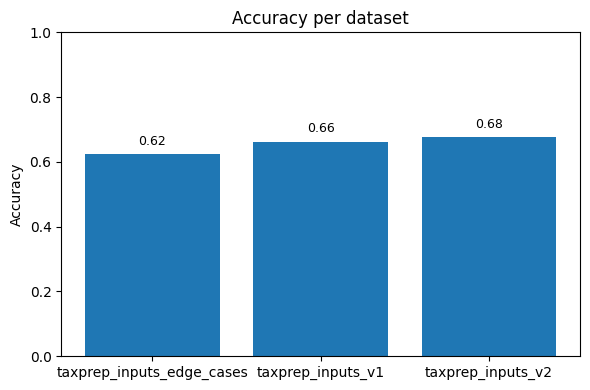

In [7]:

# ========================
# 6) Accuracy per file plot
# ========================
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(per_file_df["dataset"], per_file_df["accuracy"])
ax.set_ylim(0, 1)
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy per dataset")
for i, v in enumerate(per_file_df["accuracy"]):
    ax.text(i, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=9)
fig.tight_layout()
fig.savefig("accuracy_per_file.png", dpi=160)
plt.show()


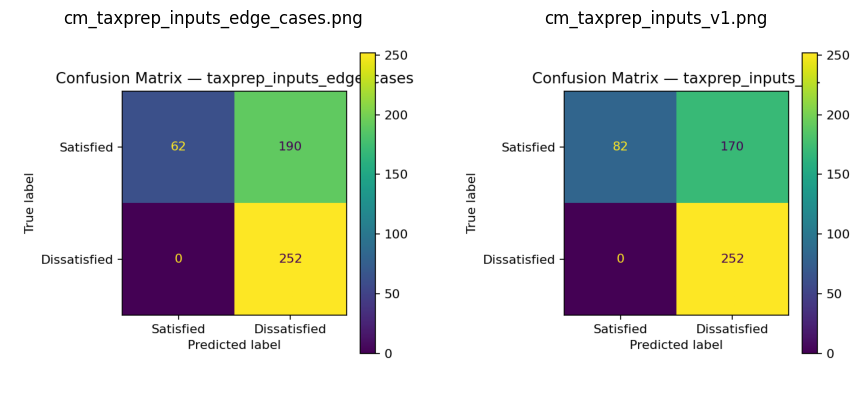

In [8]:

# ===============================================
# 7) Quick side-by-side preview of confusion plots
# ===============================================
import matplotlib.image as mpimg

imgs = cm_images[:2] if len(cm_images) >= 2 else cm_images
if imgs:
    fig, axes = plt.subplots(1, len(imgs), figsize=(4.5*len(imgs), 4))
    if len(imgs) == 1:
        axes = [axes]
    for ax, img in zip(axes, imgs):
        ax.imshow(mpimg.imread(img))
        ax.axis('off')
        ax.set_title(img)
    fig.tight_layout()
    fig.savefig("confusions_side_by_side.png", dpi=160)
    plt.show()
else:
    print("No per-file confusion images to preview.")


In [9]:

# ==========================
# 8) Export metrics workbook
# ==========================
out_xlsx = "metrics_summary_multi.xlsx"
with pd.ExcelWriter(out_xlsx, engine="xlsxwriter") as writer:
    per_file_df.to_excel(writer, index=False, sheet_name="per_file_metrics")
    # Overall summary as a one-row DF
    overall_df = pd.DataFrame([{"overall_accuracy": overall_acc}])
    overall_df.to_excel(writer, index=False, sheet_name="overall_summary")
    # Raw predictions (useful for judges to audit)

    # Keep a compact view
    preview_cols = ["__dataset__","client_id","last_feedback_text","true_label","pred_label","confidence"]
    all_df[preview_cols].to_excel(writer, index=False, sheet_name="predictions_preview")

print(f"📁 Wrote: {out_xlsx}")
print("✅ Done.")


📁 Wrote: metrics_summary_multi.xlsx
✅ Done.
